# LSTM Time Series Forecast

## Libraries

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%reload_ext autoreload

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [8]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Dataset Inspection

In [192]:
training_set = pd.read_csv('airline-passengers.csv')
training_set.head()
training_set = training_set.iloc[:,1:2].values

In [193]:
len(training_set)

144

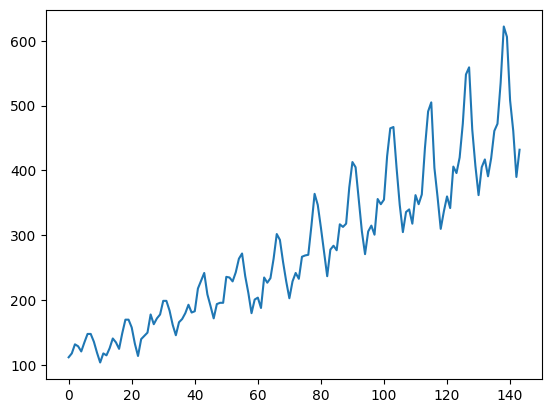

In [194]:
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [202]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [196]:
trainX.shape

torch.Size([93, 4, 1])

## Check Dataset

In [198]:
from airline_dataset import AirlineDataset

In [199]:
airline_dataset = AirlineDataset()

In [200]:
train_size = int(len(airline_dataset.labels) * 0.6)  # (first) 2/3 of the data for traning
test_size = len(airline_dataset.labels) - train_size  # (last) 1/3 of the data for testing

In [201]:
indices = list(range(len(airline_dataset)))
indices_train = indices[0: train_size]
indices_test = indices[train_size: len(airline_dataset)]
print("Indices Train Length: ", len(indices_train))
print("Indices Test Length: ", len(indices_test))
print("Indices Total Length: ", len(airline_dataset))

Indices Train Length:  83
Indices Test Length:  56
Indices Total Length:  139


In [191]:
airline_dataset.samples[0]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255]])

In [ ]:
data_train_samples = Variable(torch.Tensor(np.array(airline_dataset.data_samples[0:train_size])))
data_train_labels = Variable(torch.Tensor(np.array(airline_dataset.data_labels[0:train_size])))

## Check DataModule

In [12]:
training_set[0:5]

array([[112],
       [118],
       [132],
       [129],
       [121]])

In [13]:
from airline_dataset import AirlineDataset
from airline_dataset import AirlineDataModule

In [14]:
data_module = AirlineDataModule(batch_size=1)

In [15]:
data_module.setup()

In [16]:
data_train = data_module.train_dataloader()

In [17]:
dataiter = iter(data_train)

In [18]:
batch_data, labels = dataiter.next()
print(batch_data)
print(labels)

tensor([[[0.0154],
         [0.0270],
         [0.0541],
         [0.0483]]])
tensor([[0.0328]])


## Forecasting LSTM Model 

In [203]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [204]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.53745
Epoch: 100, loss: 0.01267
Epoch: 200, loss: 0.00457
Epoch: 300, loss: 0.00326
Epoch: 400, loss: 0.00295
Epoch: 500, loss: 0.00266
Epoch: 600, loss: 0.00242
Epoch: 700, loss: 0.00225
Epoch: 800, loss: 0.00213
Epoch: 900, loss: 0.00204
Epoch: 1000, loss: 0.00196
Epoch: 1100, loss: 0.00189
Epoch: 1200, loss: 0.00184
Epoch: 1300, loss: 0.00179
Epoch: 1400, loss: 0.00177
Epoch: 1500, loss: 0.00175
Epoch: 1600, loss: 0.00174
Epoch: 1700, loss: 0.00173
Epoch: 1800, loss: 0.00172
Epoch: 1900, loss: 0.00172


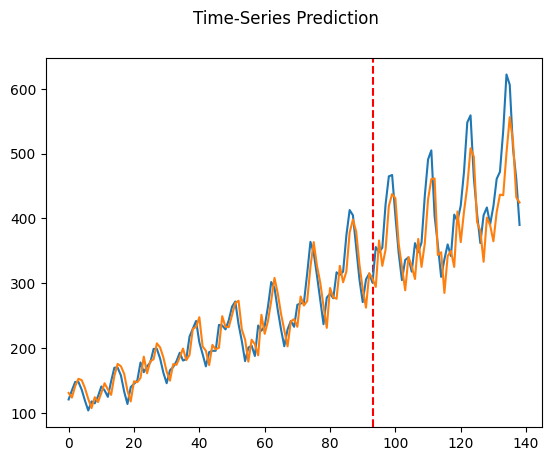

In [205]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## LSTM Forecast with PyTorch Lightning

In [150]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.plugins.environments import SLURMEnvironment
from pytorch_lightning.callbacks import LearningRateMonitor
from pl_bolts.callbacks import TrainingDataMonitor

In [151]:
from airline_dataset import AirlineDataset
from airline_dataset import AirlineDataModule
from lstm_forecast_model import LSTM
from lstm_forecast_model import LstmPredModule

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [153]:
torch.cuda.empty_cache()

In [154]:
pl.seed_everything(100)

Global seed set to 100


100

In [155]:
checkpoint_callback = ModelCheckpoint(monitor="validation_loss",
                                      mode='min',
                                      every_n_epochs=1,
                                      save_top_k=3,
                                      save_last=True,
                                      save_on_train_epoch_end=False)

monitor = TrainingDataMonitor(log_every_n_steps=20)

In [156]:
progress_bar = RichProgressBar(theme=RichProgressBarTheme(description="green_yellow",
                                                          progress_bar="green1",
                                                          progress_bar_finished="green1",
                                                          batch_progress="green_yellow",
                                                          time="grey82",
                                                          processing_speed="grey82",
                                                          metrics="grey82"))

In [157]:
data_module = AirlineDataModule(batch_size=120, train_size=0.8, drop_last=False)
data_module.setup()

In [158]:
train_loader = data_module.train_dataloader()
valid_loader = data_module.val_dataloader()

print(len(train_loader))
print(len(valid_loader))

1
1


In [132]:
dataiter = iter(train_loader)

In [133]:
batch_data, labels = dataiter.next()
print(batch_data)
print(labels)

tensor([[[0.0154],
         [0.0270],
         [0.0541],
         [0.0483]],

        [[0.0270],
         [0.0541],
         [0.0483],
         [0.0328]],

        [[0.0541],
         [0.0483],
         [0.0328],
         [0.0598]],

        [[0.0483],
         [0.0328],
         [0.0598],
         [0.0849]],

        [[0.0328],
         [0.0598],
         [0.0849],
         [0.0849]],

        [[0.0598],
         [0.0849],
         [0.0849],
         [0.0618]],

        [[0.0849],
         [0.0849],
         [0.0618],
         [0.0290]],

        [[0.0849],
         [0.0618],
         [0.0290],
         [0.0000]],

        [[0.0618],
         [0.0290],
         [0.0000],
         [0.0270]],

        [[0.0290],
         [0.0000],
         [0.0270],
         [0.0212]],

        [[0.0000],
         [0.0270],
         [0.0212],
         [0.0425]],

        [[0.0270],
         [0.0212],
         [0.0425],
         [0.0714]],

        [[0.0212],
         [0.0425],
         [0.0714],
       

In [134]:
print(batch_data.shape)
print(labels.shape)

torch.Size([111, 4, 1])

In [141]:
batch_data_np = batch_data.cpu().numpy()
labels_np = labels.cpu().numpy()

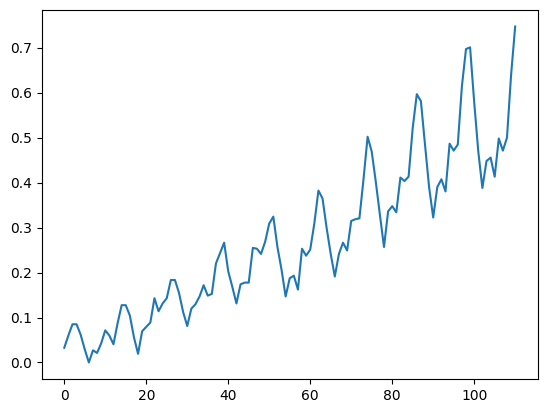

In [143]:
plt.plot(labels_np)
plt.show()

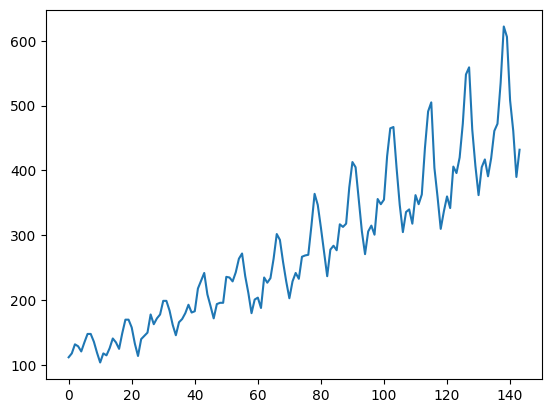

In [30]:
plt.plot(data_module.airline_dataset.data)
plt.show()

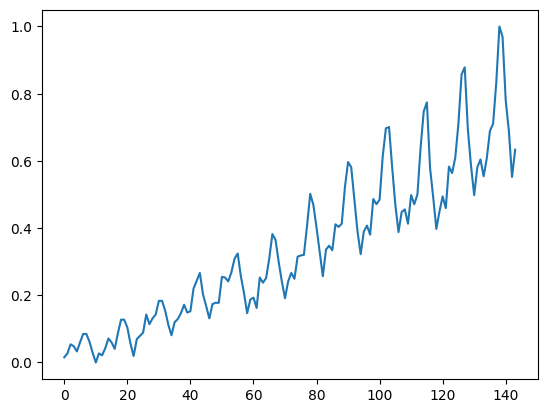

In [248]:
plt.plot(data_module.airline_dataset.data_scaled)
plt.show()

In [159]:
model_module = LstmPredModule(learning_rate=1e-2)
# model_module = LstmPredModule(learning_rate=1e-3, hidden_size=16)

In [238]:
max_nro_epochs = 2000
trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,
                     max_epochs=max_nro_epochs,
                     callbacks=[progress_bar, checkpoint_callback])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
# trainer.fit(model_module, datamodule=data_module)

## Test LSTM Forecaster

In [239]:
model_module = LstmPredModule.load_from_checkpoint("./lightning_logs/version_12/checkpoints/epoch=1999-step=2000.ckpt")

In [240]:
print(model_module.hidden_size)

2


In [241]:
data_module = AirlineDataModule(batch_size=120, train_size=0.8, drop_last=False)
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()

In [237]:
dataiter = iter(train_loader)

In [62]:
batch_data, labels = dataiter.next()
print(batch_data)
print(labels)

tensor([[[0.0154],
         [0.0270],
         [0.0541],
         [0.0483]],

        [[0.0270],
         [0.0541],
         [0.0483],
         [0.0328]],

        [[0.0541],
         [0.0483],
         [0.0328],
         [0.0598]],

        [[0.0483],
         [0.0328],
         [0.0598],
         [0.0849]],

        [[0.0328],
         [0.0598],
         [0.0849],
         [0.0849]],

        [[0.0598],
         [0.0849],
         [0.0849],
         [0.0618]],

        [[0.0849],
         [0.0849],
         [0.0618],
         [0.0290]],

        [[0.0849],
         [0.0618],
         [0.0290],
         [0.0000]],

        [[0.0618],
         [0.0290],
         [0.0000],
         [0.0270]],

        [[0.0290],
         [0.0000],
         [0.0270],
         [0.0212]],

        [[0.0000],
         [0.0270],
         [0.0212],
         [0.0425]],

        [[0.0270],
         [0.0212],
         [0.0425],
         [0.0714]],

        [[0.0212],
         [0.0425],
         [0.0714],
       

In [242]:
predictions_train = trainer.predict(model_module, train_loader)
predictions_test = trainer.predict(model_module, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/farnez/.virtualenvs/Semantic_Segmentation/lib/python3.7/site-packages/rich/live.py:229: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [179]:
predictions_train[0].shape

torch.Size([111, 1])

In [243]:
preds_train = torch.cat(predictions_train)
preds_test = torch.cat(predictions_test)

In [244]:
preds_train_np = preds_train.cpu().numpy()
preds_test_np = preds_test.cpu().numpy()

In [245]:
preds_np = np.concatenate((preds_train_np, preds_test_np))
# preds_np = data_module.airline_dataset.scaler.inverse_transform(preds_np)

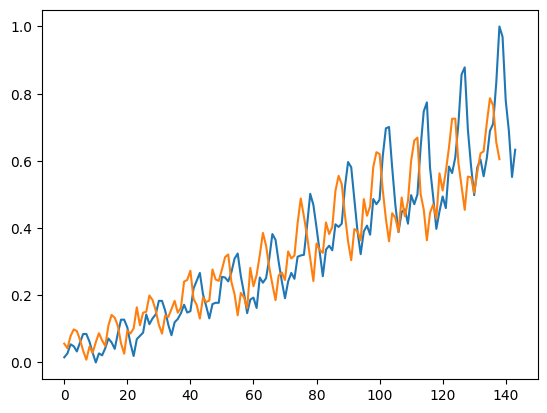

In [249]:
plt.plot(data_module.airline_dataset.data_scaled)
plt.plot(preds_np)
plt.show()